In [ ]:
from google.colab import drive
drive.mount('content/drive')

# 環境構築

In [ ]:
!pip install fugashi==1.1.2 ipadic==1.0.0 unidic-lite
!pip install matplotlib==3.5.2 seaborn numpy==1.22.4 openpyxl==3.0.10 tqdm XlsxWriter==3.0.3 pandas Pillow==9.0.1 plotly==5.1.0
!pip install pytorch-lightning==1.6.4 scikit-learn scipy==1.8.1 transformers==4.19.2 tokenizers==0.12.1 sklearn==0.0 shap

### ライブラリのインポート，ファイルパスの設定

In [2]:
from tqdm import tqdm
from IPython.display import display
import pandas as pd
import numpy as np
import shutil
import os
import glob
import argparse
import random

import torch
from torch.utils.data import DataLoader
from transformers import CONFIG_NAME, WEIGHTS_NAME, BertForSequenceClassification, BertJapaneseTokenizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import StochasticWeightAveraging

#MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'
MODEL_NAME = 'cl-tohoku/bert-base-japanese-v2'

TRAIN_PATH = 'path/to/train/dataset.txt'
TEST_PATH = 'path/to/test/dataset.txt'
FOLD = 10
LABEL_LIST = ['A','FT','L','LF','MN','O','PE','PO','SC','SE','US','A_C']
THRESHOLD = -1.0 #default=0

### ModelExplainerクラス shapライブラリで分類結果を分析します。

In [3]:
import shap
import transformers
import numpy as np

class ModelExplainer():
    def __init__(self, model, tokenizer, labels):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels
    
    def shap_explainer(self, features, answers, predicts):
        data = np.array(features)
        pred = transformers.pipeline("text-classification",model=self.model,tokenizer=self.tokenizer,device=0,return_all_scores=True)
        explainer = shap.Explainer(pred,output_names=list(self.labels))
        print("♦SHAP可視化結果")
        for feature, answer, predict in zip(features, answers, predicts):
            print(f"予測ラベル: {predict} ,正解ラベル: {answer}")
            print(feature)
            shap_values = explainer([feature])
            shap.plots.text(shap_values)

### Excel シートの生成

In [13]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import collections
#import squarify
import plotly.graph_objects as go
import seaborn as sb

def makeClassificationResultSheet_ml(classification_result, report_result, index2label, scores_df):
    #予測ラベルから分布図を作成
    predicted_label = classification_result['predicted_label']
    all_label = []
    for labels in predicted_label:
        lst = labels.split(',')
        for label in lst:
            all_label.append(label)

    count = collections.Counter(all_label)
    dist_label = []
    for label in index2label.values():
        if label in count:
            dist_label.append(count[label])
        else:
            dist_label.append(0)
    #グラフをメモリに一時保存
    img = io.BytesIO()
    fig, ax = plt.subplots() #stacked bar
    ax.bar(index2label.values(), dist_label,label='quantity')
    ax.legend()
    fig.savefig(img,format='png')

    #print(dist_label)
    #分類結果をxlsxで出力
    writer = pd.ExcelWriter('classification_result_ml.xlsx',engine='xlsxwriter')
    classification_result.to_excel(writer,sheet_name='result',encoding='utf_8_sig',freeze_panes=[1,0])
    #classification_reportを出力
    report_result.to_excel(writer,sheet_name='classification_report')
    #classification_scoresを出力
    scores_df.to_excel(writer,sheet_name='classification_scores',freeze_panes=[1,0])
    #エクセルシートの装飾
    for column in classification_result:
        column_length = max(classification_result[column].astype(str).map(len).max(),len(column))
        col_idx = classification_result.columns.get_loc(column)
        writer.sheets['result'].set_column(col_idx+1,col_idx+1,column_length)
    
    workbook = writer.book
    color_format = workbook.add_format({'bg_color': '#9fff9c'})
    row = len(classification_result.axes[0])+1
    writer.sheets['result'].conditional_format('C2:C'+str(row),{
        'type': 'formula',
        'criteria': '=$B2=$C2',
        'format': color_format
    })
    writer.sheets['result'].conditional_format('D2:D'+str(row),{
        'type': 'formula',
        'criteria': '=$B2=$D2',
        'format': color_format
    })
    writer.sheets['result'].conditional_format('E2:E'+str(row),{
        'type': 'formula',
        'criteria': '=$B2=$E2',
        'format': color_format
    })
    for index in range(len(scores_df.index)):
        writer.sheets['classification_scores'].conditional_format(
            'B'+str(index+2)+':'+'L'+str(index+2),
            {'type': '3_color_scale',
            'max_color': '#51f569',
            'mid_color': 'white',
            'min_color': '#f55151'}
        )

    writer.sheets['classification_report'].set_column(0,0,13)
    #グラフを出力
    writer.sheets['classification_report'].insert_image('G2','graph',{'image_data': img})

    writer.save()

def makeReqAnalysisSheet_ml(classification_result, index2label):
    predicted_label = classification_result['predicted_label']
    all_label = []
    for labels in predicted_label:
        lst = labels.split(',')
        for label in lst:
            all_label.append(label)

    count = collections.Counter(all_label)
    print(count)
    dist_label = []
    for label in index2label.values():
        if label in count:
            dist_label.append(count[label])
        else:
            dist_label.append(0)

    #squarifyツリーマップ
    """ treemap = io.BytesIO()
    fig = plt.figure(figsize=(6,3))
    plt.axis('off')
    axis = squarify.plot(count.values(),label=count.keys(),color=sb.color_palette('Spectral',12),pad=1,text_kwargs={'fontsize': 12})
    axis.set_title('NFR Types')
    fig.savefig(treemap,format='png') """

    #アクセス制御のラベルを分離
    nfr_type = []
    is_ac = []
    nfr_child = 0
    fr_child = 0
    for label in predicted_label:
        if 'A_C' in label:
            if label == 'A_C':
                nfr_type.append('OTHER')
                fr_child += 1
            else:
                nfr_type.append(label.replace(',A_C',''))
                nfr_child += 1
            is_ac.append('detected')
        else:
            nfr_type.append(label)
            is_ac.append('')

    #plotlyツリーマップ
    count.pop('A_C',None)
    label_length = len(list(count.values()))
    labels = list(count.keys())+ ['AC','AC(NFR)']
    parents = ['' for i in range(label_length)] + ['OTHER','SE']
    values = list(count.values())
    values.append(fr_child)
    values.append(nfr_child)
    print(values)
    fig1 = go.Figure(go.Treemap(
        labels= labels,
        values= values,
        parents= parents,
        hovertemplate='<b>%{label} </b> <br>%{value}<br>Parent Ratio: %{percentParent:.2f}',
        textinfo="label+value",
    ))
    fig2 = go.Figure(go.Treemap(
        labels= labels,
        values= values,
        parents= parents,
        hovertemplate='<b>%{label} </b> <br>%{value}<br>Parent Ratio: %{percentParent:.2f}',
        textinfo="label+value+percent parent+percent root",
        #textinfo="label+value,"
    ))
    fig1.update_layout(
        font=dict(
        family="Times New Roman",
        size=20,
        color="Black"
        ),
        margin = dict(t=10, l=5, r=5, b=25),
    )
    fig2.update_layout(
        font=dict(
        family="Times New Roman",
        size=20,
        color="Black"
        ),
        margin = dict(t=50, l=25, r=25, b=25),
    )
    treemap2 = io.BytesIO()
    #fig2.show()
    fig2.write_image(treemap2,format='png', scale=1.3, engine='kaleido')

    treemap = io.BytesIO()
    fig1.write_image(treemap,format='png', scale=0.8, engine='kaleido')

    #アクセス制御のラベルを分離
    nfr_type = []
    is_ac = []
    for label in predicted_label:
        if 'A_C' in label:
            if label == 'A_C':
                nfr_type.append('OTHER')
            else:
                nfr_type.append(label.replace(',A_C',''))
            is_ac.append('detected')
        else:
            nfr_type.append(label)
            is_ac.append('')
    
    new_df = pd.DataFrame({
            'NFR Type': nfr_type,
            'Acces Control': is_ac,
            'Requirement Sentence': classification_result['text'],
        },index=np.arange(1,len(nfr_type)+1))
    writer = pd.ExcelWriter('requirements_analysis_ml.xlsx',engine='xlsxwriter')
    new_df.to_excel(writer,'Analysis Result',freeze_panes=[1,0])
    #エクセルシートの装飾
    for column in new_df:
        column_length = max(new_df[column].astype(str).map(len).max(),len(column))
        col_idx = new_df.columns.get_loc(column)
        writer.sheets['Analysis Result'].set_column(col_idx+1,col_idx+1,column_length)
    workbook = writer.book
    color_format = workbook.add_format({'bg_color': '#fc2163'})
    row = len(new_df.axes[0])+1
    writer.sheets['Analysis Result'].conditional_format('C2:C'+str(row),{
        'type': 'formula',
        'criteria': '$C2="detected"',
        'format': color_format
    })
    #ツリーマップを出力
    placement = len(predicted_label) + 3
    writer.sheets['Analysis Result'].insert_image(f'B{placement}','graph',{'image_data': treemap})

    writer.save()

## 学習クラス

In [6]:
class BertMultiLabelClassifier_pl(pl.LightningModule):

    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters()
        self.bert_mlc = BertForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=num_labels,
            problem_type="multi_label_classification",
            attention_probs_dropout_prob=0.2,
            hidden_dropout_prob=0.2,
        )

    def training_step(self, batch, batch_idx):
        output = self.bert_mlc(
            input_ids=batch['input_ids'],
            token_type_ids=batch['token_type_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels'].float()
        )
        loss = output.loss
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        output = self.bert_mlc(
            input_ids=batch['input_ids'],
            token_type_ids=batch['token_type_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels'].float()
        )
        val_loss = output.loss
        scores = output.logits
        labels_predicted = (scores > 0).int()
        labels = batch.pop('labels')
        num_correct = ( labels_predicted == labels ).all(-1).sum().item()
        val_acc = num_correct/scores.size(0)
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)

    def test_step(self, batch, batch_idx):
        labels = batch.pop('labels')
        output = self.bert_mlc(**batch)
        scores = output.logits
        labels_predicted = (scores > 0).int()
        num_correct = ( labels_predicted == labels ).all(-1).sum().item()
        accuracy = num_correct/scores.size(0)
        self.log('accuracy', accuracy)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr,weight_decay=1e-2)
        return optimizer

## モデルの構築，予測

In [7]:
class BertModelHandler():
    def __init__(self, data, label_list):
        self.data = data
        self.label_list = label_list
    
    # BERTをファインチューニングして保存する
    def trainingTaskKFold_ml(self, generalization = False):
        if os.path.exists('model_ml/'):
            shutil.rmtree('model_ml/')
    
        if generalization:
            num_of_training = FOLD
        else:
            num_of_training = 1
    
        dataloader_test = DataLoader(self.data['test_data'], batch_size=256)

        #層化K分割で学習データと検証データに分割してファインチューニング
        accuracy = []
        training_data_amounts = []
        val_data_amounts = []
        best_model_paths = []
        skf = StratifiedKFold(n_splits=FOLD)
        for fold, (train_index, val_index) in enumerate(skf.split(X=self.data['dataset'],y=self.data['dataset_idx'])):
        
            train_data = [self.data['dataset'][i] for i in train_index]
            val_data = [self.data['dataset'][i] for i in val_index]
            random.shuffle(train_data)
            training_data_amounts.append(len(train_data))
            val_data_amounts.append(len(val_data))
            dataloader_train = DataLoader(train_data, batch_size=32, shuffle=True)
            dataloader_val = DataLoader(val_data, batch_size=256)
            
            model = BertMultiLabelClassifier_pl(
                MODEL_NAME, num_labels=self.data['num_labels'], lr=1e-5,
            )
            checkpoint = pl.callbacks.ModelCheckpoint(
                filename=f'fold={fold+1}'+'-{epoch}-{step}-{val_loss:.1f}',
                monitor='val_loss',
                mode='min',
                save_top_k=1,
                #save_last=1,
                save_weights_only=True,
                dirpath='model_ml/',
            )
            early_stop = (
                EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    mode='min'
                )
            )
            weight_averaging = (
                StochasticWeightAveraging(swa_lrs=1e-5)
            )
            # 学習方法
            trainer = pl.Trainer(
                gpus=1,
                max_epochs=40,
                log_every_n_steps=10,
                callbacks=[checkpoint, early_stop, weight_averaging]
            )
            # ファインチューニング
            trainer.fit(model,train_dataloaders=dataloader_train,val_dataloaders=dataloader_val)

            print('best model: ', checkpoint.best_model_path)
            print('val_loss: ', checkpoint.best_model_score)
        
            best_model_path = checkpoint.best_model_path

            test = trainer.test(dataloaders=dataloader_test,ckpt_path=best_model_path)
            print(f'Accuracy: {test[0]["accuracy"]:.3f}')
            accuracy.append(test[0]["accuracy"])

            if num_of_training == 1:
                tmp_df = pd.DataFrame({
                    'amount': training_data_amounts,
                    'val_amounts': val_data_amounts
                })
                tmp_df.to_csv('./model_ml/training_data_amounts.csv')
                model = BertMultiLabelClassifier_pl.load_from_checkpoint(best_model_path)
                model.bert_mlc.save_pretrained('./model_transformers_ml/')
                break
            else:
                tmp_df = pd.DataFrame({
                    'amount': training_data_amounts,
                    'val_amounts': val_data_amounts
                })
                tmp_df.to_csv('./model_ml/training_data_amounts.csv')
                best_model_paths.append(best_model_path)
        
        if num_of_training != 1:
            print(f'Average accuracy: {np.mean(accuracy):.3f}')
            print('Starting weight averaging task ...')
            tmp_df = pd.DataFrame({
                'amount': training_data_amounts,
                'val_amounts': val_data_amounts
            })
            tmp_df.to_csv('./model_ml/training_data_amounts.csv')
            #print(tmp_df)
    
    #保存済みモデルで予測して評価する
    def predictAndEvaluate_ml(self, mode='gpu'):
        #保存済みモデルをロード
        bert_mlc = BertForSequenceClassification.from_pretrained(
            './model_transformers_ml/'
        )
        tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
        #符号化
        encoding = tokenizer(
            self.data['test_data_list'],
            padding= 'longest',
            return_tensors='pt'
        )
        if mode == 'gpu':
            #GPUにのせる
            bert_mlc = bert_mlc.cuda()
            encoding = { k: v.cuda() for k, v in encoding.items() }
        else:
            encoding = { k: v for k, v in encoding.items() }
        #予測する
        with torch.no_grad():
            output = bert_mlc(**encoding)
        scores = output.logits #分類スコア
        print(scores)
        labels_predicted = ( scores > THRESHOLD ).int().cpu().numpy().tolist() #予測ラベル(ex.[[1,0],[0,0]])
    
        #CPUに戻す
        #labels_predicted = labels_predicted.cpu()
        scores = scores.cpu()

        #予測Multi-hotラベルを多クラスラベルに変換する
        predicted = []
        for multi_hot in labels_predicted:
            tmp = []
            for idx, true_or_false in enumerate(multi_hot):
                if true_or_false == 1:
                    tmp.append(self.data['index2label'][idx])
            if not tmp:
                predicted.append('OTHER')
            else:
                predicted.append(",".join(tmp))       
    
        #正解Multi-hotラベルを多クラスラベルに変換する
        answer = []
        for multi_hot in self.data['test_data_answer']:
            tmp = []
            for idx, true_or_false in enumerate(multi_hot):
                if true_or_false == 1:
                    tmp.append(self.data['index2label'][idx])
            if not tmp:
                answer.append('OTHER')
            else:
                answer.append(",".join(tmp))

        #print('予測ラベル: ',labels_predicted)
        #print('正解ラベル: ',self.data['test_data_answer'])

        target_names = self.data['index2label'].values()
        
        report = classification_report(
            self.data['test_data_answer'], labels_predicted, target_names=target_names, output_dict=True, zero_division=0
        )

        report_result = pd.DataFrame(report).T
        display(report_result)

        classification_result = pd.DataFrame({
            'answer_label': answer,
            'predicted_label': predicted,
            'text': self.data['test_data_list'],
        },index=np.arange(1,len(predicted)+1))

        scores_df = pd.DataFrame(scores,columns=self.data['index2label'].values(),index=np.arange(1,len(predicted)+1))

        index2label = self.data['index2label']
        makeClassificationResultSheet_ml(classification_result,report_result,index2label,scores_df)
        makeReqAnalysisSheet_ml(classification_result, index2label)
        modelExplainer = ModelExplainer(model=bert_mlc,tokenizer=tokenizer,labels=target_names)
        modelExplainer.shap_explainer(self.data['test_data_list'],self.data['test_data_answer'],predicted)

def predict(features):
    #保存済みモデルをロード
    bert_mlc = BertForSequenceClassification.from_pretrained(
        './model_transformers_ml/'
    )
    tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
    #符号化
    encoding = tokenizer(
        list(features),
        padding= 'longest',
        return_tensors='pt'
    )
    bert_mlc.cuda()
    encoding = { k: v.cuda() for k, v in encoding.items() }
    with torch.no_grad():
        output = bert_mlc.forward(**encoding)
    return output.logits.cpu()

## データセットの読み込み

In [9]:
def loadDatasets_ml(train_path, test_path, label_list):
    train_df = pd.read_csv(f'{train_path}', encoding='cp932')
    test_df = pd.read_csv(f'{test_path}', encoding='cp932')

    index2label = {i: k for i, k in enumerate(label_list)}
    label2index = {k: i for i, k in enumerate(label_list)}
    answers = [test_df[label] for label in label_list]
    label2answers = {label: answers_array for label, answers_array in zip(label_list, answers)}
    
    test_data_list = test_df['feature'].tolist()
    num_labels = len(label_list)

    dataset_for_loader = []
    test_dataset_for_loader = []

    max_length = 128  # トークン数
    tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

    dataset_idx = []
    for idx, row in tqdm(train_df.iterrows()):
        encoding = tokenizer(
                row['feature'],
                max_length=max_length,
                padding='max_length',
                truncation=True
            )
        encoding['labels'] = [row[label] for label in label_list]  # ラベルを追加
        encoding = {k: torch.tensor(v) for k, v in encoding.items()}
        dataset_for_loader.append(encoding)
        dataset_idx.append(convertMultihotVector2tmpLabel(encoding['labels'].tolist()))
    
    test_answer = []
    for idx, row in tqdm(test_df.iterrows()):
        encoding = tokenizer(
                row['feature'],
                max_length=max_length,
                padding='max_length',
                truncation=True
            )
        encoding['labels'] = [row[label] for label in label_list]  # ラベルを追加
        test_answer.append([row[label] for label in label_list])
        encoding = {k: torch.tensor(v) for k, v in encoding.items()}
        test_dataset_for_loader.append(encoding)

    return {
        'num_labels': num_labels,
        'index2label': index2label,
        'label2index': label2index,
        'dataset': dataset_for_loader,
        'dataset_idx': dataset_idx,
        'test_data': test_dataset_for_loader,
        'test_data_answer': test_answer,
        'label2answers': label2answers,
        'test_data_list': test_data_list,
    }

#one-hot形式のラベルを一時的なマルチクラスのラベルに変換する
def convertMultihotVector2tmpLabel(mlt_hot):
    length = len(mlt_hot)
    label = None
    for idx, single_one_hot_vector in enumerate(np.identity(length,dtype=int).tolist()):
        if single_one_hot_vector == mlt_hot:
            label = idx
    if label == None:
        label = length + 1 #Other
    return label

## メインタスク

In [10]:
print('Is CUDA available?: ',torch.cuda.is_available())

data = loadDatasets_ml(TRAIN_PATH, TEST_PATH, LABEL_LIST)
bmh = BertModelHandler(data, LABEL_LIST)

Is CUDA available?:  True


735it [00:02, 347.20it/s] 
121it [00:00, 1632.56it/s]


### 学習の実行

In [ ]:
print('Starting training task...')
bmh.trainingTaskKFold_ml()
bmh.predictAndEvaluate_ml()

### 予測の実行

tensor([[-1.8388, -2.1017, -3.5973,  ..., -1.1699, -3.7312, -2.7192],
        [-2.5320, -2.6634, -3.5464,  ..., -0.7969, -3.6568, -1.8173],
        [-1.9592, -2.7519, -3.1280,  ..., -2.6093, -3.5719, -3.3813],
        ...,
        [-2.4564, -3.0563, -3.1613,  ..., -4.1394, -0.9657, -3.0315],
        [-3.3239, -2.7157, -1.6590,  ..., -2.8888, -2.8371, -2.9959],
        [-1.4673, -1.3901, -3.3481,  ..., -2.6425, -3.3287, -3.4467]],
       device='cuda:0')
予測ラベル:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], [

,precision,recall,f1-score,support
A,1.000000,0.500000,0.666667,6.0
FT,0.000000,0.000000,0.000000,0.0
L,1.000000,0.250000,0.400000,4.0
LF,1.000000,1.000000,1.000000,2.0
MN,0.000000,0.000000,0.000000,2.0
O,0.000000,0.000000,0.000000,6.0
PE,0.333333,0.500000,0.400000,2.0
PO,0.000000,0.000000,0.000000,0.0
SC,0.000000,0.000000,0.000000,14.0
SE,0.166667,0.400000,0.235294,10.0


[3, 0, 1, 2, 0, 5, 3, 1, 0, 24, 4, 8]
Counter({'OTHER': 80, 'SE': 24, 'A_C': 8, 'O': 5, 'US': 4, 'PE': 3, 'A': 3, 'LF': 2, 'PO': 1, 'L': 1})
[80, 24, 5, 4, 2, 3, 3, 1, 1, 0, 8]


the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
save is not part of the public API, usage can give unexpected results and will be removed in a future version


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

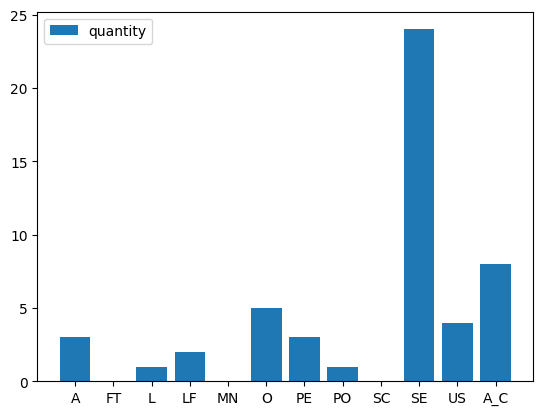

In [14]:
bmh.predictAndEvaluate_ml()